In [1]:
import h5py
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU,TimeDistributed, Conv1D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
import os
import h5py
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow.keras.regularizers import l1
import ast
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from pandas import read_csv
from keras.wrappers.scikit_learn import KerasClassifier


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Go Through File and Create Dataframes

In [5]:
f = h5py.File('drive/Shareddrives/Jet Classification/Data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z','r')
treeArray = f['t_allpar_new'][()]

features = ['j_zlogz', 'j_c1_b0_mmdt','j_c1_b1_mmdt', 'j_c1_b2_mmdt' , 'j_c2_b1_mmdt',
            'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 
            'j_n2_b2_mmdt', 'j_mass_mmdt', 'j_multiplicity', 'j1_etarel','j1_phirel','j1_pt','j1_e','j1_ptrel','j1_erel','j1_deltaR','j_index']
featuresUsed = ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR', 'j1_pdgid','j_index']
pdgid = ['j_index', 'j1_pdgid']
glob = ['j_mass_mmdt', 'j_mass' ,'j_index']
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']


### Group Features in Dataframe by Jet Index

In [6]:
features_df = pd.DataFrame(treeArray,columns=features)

In [7]:
index_df = features_df[features].groupby(['j_index'])

In [16]:
index_df.first()

,j_zlogz,j_c1_b0_mmdt,j_c1_b1_mmdt,j_c1_b2_mmdt,j_c2_b1_mmdt,j_c2_b2_mmdt,j_d2_b1_mmdt,j_d2_b2_mmdt,j_d2_a1_b1_mmdt,j_d2_a1_b2_mmdt,j_m2_b1_mmdt,j_m2_b2_mmdt,j_n2_b1_mmdt,j_n2_b2_mmdt,j_mass_mmdt,j_multiplicity,j1_etarel,j1_phirel,j1_pt,j1_e,j1_ptrel,j1_erel,j1_deltaR
j_index,,,,,,,,,,,,,,,,,,,,,,,
1,-2.018162,0.350997,0.029745,0.006877,0.069028,0.009892,2.320638,1.438492,2.320638,0.107106,0.036578,0.010557,0.239372,0.087167,90.774467,43.0,-0.002755,-0.024659,573.877441,621.589478,0.526719,0.525633,0.024813
3,-1.229667,0.248067,0.053452,0.012612,0.056938,0.011764,1.065204,0.932719,1.065204,0.114851,0.045726,0.026556,0.196152,0.118938,148.984619,36.0,-0.046575,-0.033144,912.233521,1025.121826,0.689462,0.699932,0.057165
7,-2.779230,0.413870,0.070661,0.021536,0.081898,0.016286,1.159015,0.756235,1.159015,0.129390,0.053760,0.019545,0.220432,0.093826,241.290421,78.0,-0.052698,0.060146,634.409241,637.664490,0.390835,0.388123,0.079966
21,-3.556037,0.474108,0.046254,0.008617,0.082200,0.020396,1.777132,2.366941,1.777132,0.219858,0.087417,0.038829,0.321610,0.189189,128.277725,108.0,-0.039642,-0.019943,177.829224,210.623428,0.133965,0.130639,0.044376
23,-3.479324,0.473567,0.057860,0.014811,0.101485,0.019440,1.753973,1.312522,1.753973,0.188489,0.085409,0.031940,0.313160,0.134335,146.673401,88.0,0.006637,0.061119,151.889832,152.321976,0.130030,0.129065,0.061479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400199939,-3.827506,0.483626,0.080682,0.020222,0.115335,0.026454,1.429495,1.308200,1.429495,0.261085,0.124706,0.065940,0.330142,0.170779,170.516800,81.0,-0.213833,-0.075494,94.362823,116.092384,0.079498,0.068866,0.226768
400199945,-3.566062,0.474319,0.106276,0.036021,0.139440,0.040334,1.312054,1.119728,1.312054,0.230365,0.109543,0.058171,0.298426,0.148729,201.762924,87.0,0.017117,0.059135,169.539261,172.701096,0.162039,0.158689,0.061562
400199962,-3.722681,0.483903,0.105904,0.032945,0.122986,0.032659,1.161294,0.991335,1.161294,0.230676,0.118653,0.071008,0.319430,0.191160,182.791061,75.0,-0.076911,-0.250765,66.630859,99.012939,0.067352,0.063112,0.262295


In [9]:
index_df.last()

,j_zlogz,j_c1_b0_mmdt,j_c1_b1_mmdt,j_c1_b2_mmdt,j_c2_b1_mmdt,j_c2_b2_mmdt,j_d2_b1_mmdt,j_d2_b2_mmdt,j_d2_a1_b1_mmdt,j_d2_a1_b2_mmdt,j_m2_b1_mmdt,j_m2_b2_mmdt,j_n2_b1_mmdt,j_n2_b2_mmdt,j_mass_mmdt,j_multiplicity,j1_etarel,j1_phirel,j1_pt,j1_e,j1_ptrel,j1_erel,j1_deltaR
j_index,,,,,,,,,,,,,,,,,,,,,,,
1,-2.018162,0.350997,0.029745,0.006877,0.069028,0.009892,2.320638,1.438492,2.320638,0.107106,0.036578,0.010557,0.239372,0.087167,90.774467,43.0,-0.000255,0.167938,5.371203e-12,5.812193e-12,4.929822e-15,4.914950e-15,0.167938
3,-1.229667,0.248067,0.053452,0.012612,0.056938,0.011764,1.065204,0.932719,1.065204,0.114851,0.045726,0.026556,0.196152,0.118938,148.984619,36.0,0.025269,-0.215369,2.306876e-01,2.514011e-01,1.743528e-04,1.716514e-04,0.216846
7,-2.779230,0.413870,0.070661,0.021536,0.081898,0.016286,1.159015,0.756235,1.159015,0.129390,0.053760,0.019545,0.220432,0.093826,241.290421,78.0,0.226063,-0.294880,3.668080e-12,3.726016e-12,2.259763e-15,2.267890e-15,0.371562
21,-3.556037,0.474108,0.046254,0.008617,0.082200,0.020396,1.777132,2.366941,1.777132,0.219858,0.087417,0.038829,0.321610,0.189189,128.277725,108.0,-0.170488,-0.047145,2.550655e-11,2.834499e-11,1.921491e-14,1.758091e-14,0.176887
23,-3.479324,0.473567,0.057860,0.014811,0.101485,0.019440,1.753973,1.312522,1.753973,0.188489,0.085409,0.031940,0.313160,0.134335,146.673401,88.0,-0.197533,0.072032,2.017970e-01,2.034744e-01,1.727544e-04,1.724079e-04,0.210257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400199939,-3.827506,0.483626,0.080682,0.020222,0.115335,0.026454,1.429495,1.308200,1.429495,0.261085,0.124706,0.065940,0.330142,0.170779,170.516800,81.0,-0.157582,0.237563,2.254791e-01,2.869349e-01,1.899589e-04,1.702099e-04,0.285076
400199945,-3.566062,0.474319,0.106276,0.036021,0.139440,0.040334,1.312054,1.119728,1.312054,0.230365,0.109543,0.058171,0.298426,0.148729,201.762924,87.0,-0.105054,0.183578,2.072527e-10,2.176203e-10,1.980837e-13,1.999639e-13,0.211512
400199962,-3.722681,0.483903,0.105904,0.032945,0.122986,0.032659,1.161294,0.991335,1.161294,0.230676,0.118653,0.071008,0.319430,0.191160,182.791061,75.0,0.095802,0.303338,1.612507e-01,2.739642e-01,1.629955e-04,1.746291e-04,0.318107


In [10]:
max_particles = 20

In [11]:
num_features = 23

### Iterate through dataframe to create a numpy array with desired dimensions


In [19]:
data = np.zeros([98769,max_particles,num_features])
p = 0
for name, group in index_df:
    x = group.to_numpy()
    x = np.delete(x,num_features,1)
    g = 0
    for l in x:
        if g == max_particles or g == len(x): 
            break
        for n in range(num_features):
            data[p,g,n] = l[n]
        g = g+1

    p = p+1
    

In [22]:
data[10]

array([[-3.66311979e+00,  4.80191618e-01,  7.92930201e-02,
         1.85907837e-02,  1.12949684e-01,  2.30433531e-02,
         1.42445934e+00,  1.23950422e+00,  1.42445934e+00,
         2.80161530e-01,  1.37315869e-01,  6.70938864e-02,
         3.81865919e-01,  2.15957910e-01,  1.53175308e+02,
         8.40000000e+01,  1.04729692e-03,  8.89084339e-02,
         9.45216446e+01,  1.07869362e+02,  8.58973786e-02,
         8.53082240e-02,  8.89146030e-02],
       [-3.66311979e+00,  4.80191618e-01,  7.92930201e-02,
         1.85907837e-02,  1.12949684e-01,  2.30433531e-02,
         1.42445934e+00,  1.23950422e+00,  1.42445934e+00,
         2.80161530e-01,  1.37315869e-01,  6.70938864e-02,
         3.81865919e-01,  2.15957910e-01,  1.53175308e+02,
         8.40000000e+01,  1.63028657e-03,  8.43260363e-02,
         9.09971237e+01,  1.03876404e+02,  8.26944411e-02,
         8.21503997e-02,  8.43417943e-02],
       [-3.66311979e+00,  4.80191618e-01,  7.92930201e-02,
         1.85907837e-02,  1.1

### Create and group labels dataframe by index

In [23]:
labels_df = pd.DataFrame(treeArray,columns=list(labels))


In [24]:
labels_df

,j_g,j_q,j_w,j_z,j_t,j_index
0,1,0,0,0,0,101333
1,1,0,0,0,0,101333
2,1,0,0,0,0,101333
3,1,0,0,0,0,101333
4,1,0,0,0,0,101333
...,...,...,...,...,...,...
5131608,0,0,0,1,0,300123134
5131609,0,0,0,1,0,300123134
5131610,0,0,0,1,0,300123134
5131611,0,0,0,1,0,300123134


In [25]:
labels_df = labels_df.groupby('j_index')

In [26]:
labels

['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']

### Iterate through Labels Dataframe to return Numpy Array of labels

In [27]:
labels_df.first()

,j_g,j_q,j_w,j_z,j_t
j_index,,,,,
1,1,0,0,0,0
3,1,0,0,0,0
7,1,0,0,0,0
21,1,0,0,0,0
23,1,0,0,0,0
...,...,...,...,...,...
400199939,0,0,0,0,1
400199945,0,0,0,0,1
400199962,0,0,0,0,1


In [28]:
labels = np.zeros([98769,5])
o = 0
for name,  group in labels_df:
    x = group.to_numpy()
    x = np.delete(x,5,1)
    for z in range(5):
        labels[o,z] = x[0][z]

    o = o+1

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, random_state=42)


In [30]:
X_train.shape

(74076, 20, 23)

In [83]:
Inputs = Input(shape=(20,23))
x = GRU(32, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 9.999E-5, l2 = 0.0), name = 'lstm1')(Inputs)
x = Dense(128, activation='relu', kernel_initializer='lecun_uniform', name='fc4')(x)
x= Dropout(rate = 0.3)(x)
x = Dense(64, activation='relu', kernel_initializer='lecun_uniform', name='fc7')(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name = 'output_sigmoid')(x)
model = Model(inputs=Inputs, outputs=predictions)
model.summary()


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 20, 23)]          0         
_________________________________________________________________
lstm1 (GRU)                  (None, 32)                5472      
_________________________________________________________________
fc4 (Dense)                  (None, 128)               4224      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
fc7 (Dense)                  (None, 64)                8256      
_________________________________________________________________
output_sigmoid (Dense)       (None, 5)                 325       
Total params: 18,277
Trainable params: 18,277
Non-trainable params: 0
______________________________________________________

In [84]:
adam = Adam(lr = 0.0002)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train.astype('float32'), y_train.astype('float32'), batch_size = 256, epochs = 150, 
                    validation_split = 0.35, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/150
226/226 [==============================] - 3s 8ms/step - loss: 1.3112 - accuracy: 0.4672 - val_loss: 1.0151 - val_accuracy: 0.6270
Epoch 2/150
226/226 [==============================] - 1s 6ms/step - loss: 0.9923 - accuracy: 0.6363 - val_loss: 0.8856 - val_accuracy: 0.6891
Epoch 3/150
226/226 [==============================] - 1s 6ms/step - loss: 0.8923 - accuracy: 0.6882 - val_loss: 0.8367 - val_accuracy: 0.7065
Epoch 4/150
226/226 [==============================] - 1s 6ms/step - loss: 0.8566 - accuracy: 0.6987 - val_loss: 0.8191 - val_accuracy: 0.7120
Epoch 5/150
226/226 [==============================] - 1s 6ms/step - loss: 0.8394 - accuracy: 0.7021 - val_loss: 0.8046 - val_accuracy: 0.7161
Epoch 6/150
226/226 [==============================] - 1s 6ms/step - loss: 0.8183 - accuracy: 0.7135 - val_loss: 0.7954 - val_accuracy: 0.7194
Epoch 7/150
226/226 [==============================] - 1s 6ms/step - loss: 0.8197 - accuracy: 0.7108 - val_loss: 0.7918 - val_accuracy: 0.7201

In [85]:
import matplotlib.pyplot as plt


In [86]:

def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

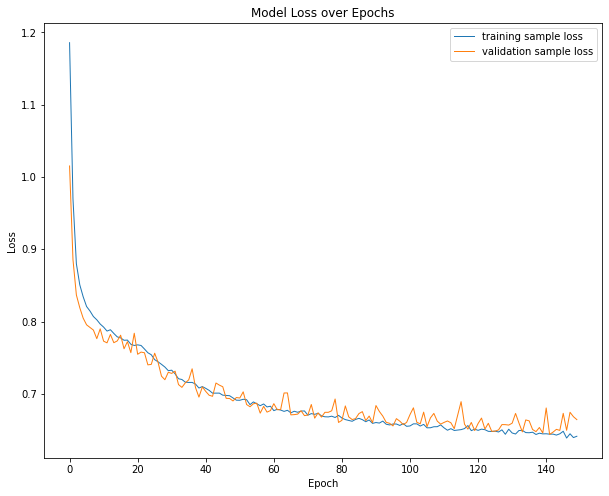

In [87]:
learningCurve(history)


In [88]:
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']


In [89]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        if i==5:
            break
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
        
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'GRU ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

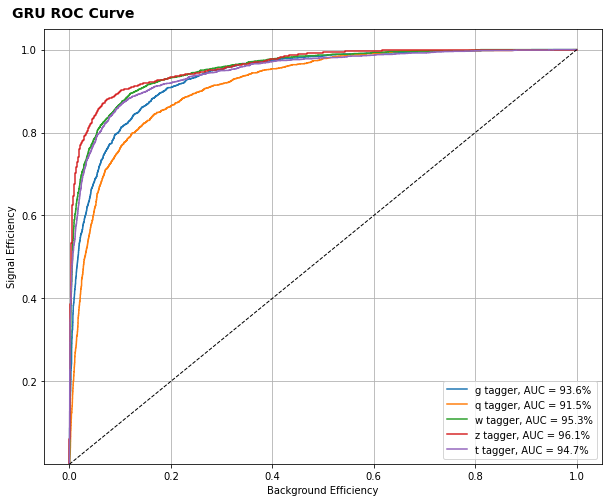

In [90]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='two-layer')


In [92]:
model.save('drive/Shareddrives/Jet Classification/Data/5tagGRU.h5', )